In [82]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

In [83]:
# load in dataset
df = pd.read_csv('SolarPrediction.csv')

# A Look at the Data

In [84]:
print(f'The shape of the dataset is {df.shape}')

The shape of the dataset is (32686, 11)


In [85]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [86]:
# check missing values
df.isnull().mean()

UNIXTime                  0.0
Data                      0.0
Time                      0.0
Radiation                 0.0
Temperature               0.0
Pressure                  0.0
Humidity                  0.0
WindDirection(Degrees)    0.0
Speed                     0.0
TimeSunRise               0.0
TimeSunSet                0.0
dtype: float64

In [87]:
df.dtypes

UNIXTime                    int64
Data                       object
Time                       object
Radiation                 float64
Temperature                 int64
Pressure                  float64
Humidity                    int64
WindDirection(Degrees)    float64
Speed                     float64
TimeSunRise                object
TimeSunSet                 object
dtype: object

## Distribution of Numerical Values

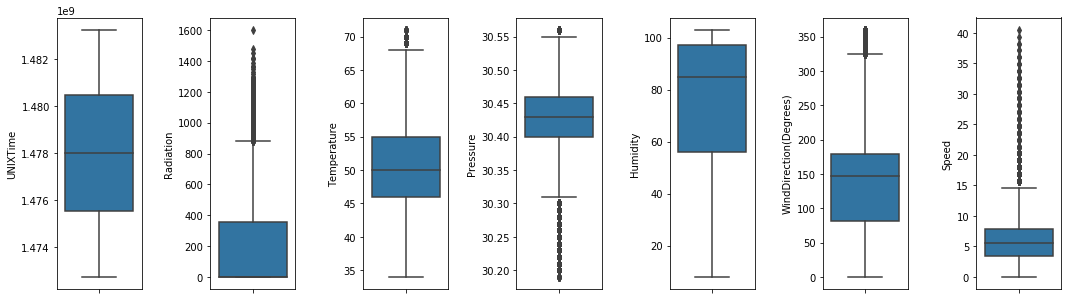

In [88]:
fig, axs = plt.subplots(1,7, figsize=(18,5))
#fig.tight_layout()
plt.subplots_adjust(wspace=0.8)
for i, feature in enumerate(df.columns[df.dtypes != 'object']):
    sns.boxplot(x=df[feature], orient='v', ax=axs[i])

We can see the Radiation is highly skewed. A great chunk of radiations are extremely small, those are measured when there's no sunshine. So I will remove the radiations measured after the sunset and before the sunrise.

# Data Cleaning

In [89]:
sun_df = df[(df['Time'] > df['TimeSunRise']) & (df['Time'] < df['TimeSunSet'])].reset_index(drop=True)
print(f'The shape of the new dataset(solar radiation during daytime) is {sun_df.shape}, we reduced the size by {df.shape[0] - sun_df.shape[0]}.')

The shape of the new dataset(solar radiation during daytime) is (15608, 11), we reduced the size by 17078.


In [90]:
# Create column Date
sun_df['Date'] = sun_df['Data'].str.rstrip(' 12:00:00 AM')
# remove column Data
sun_df.drop(['Data'], axis=1, inplace=True)

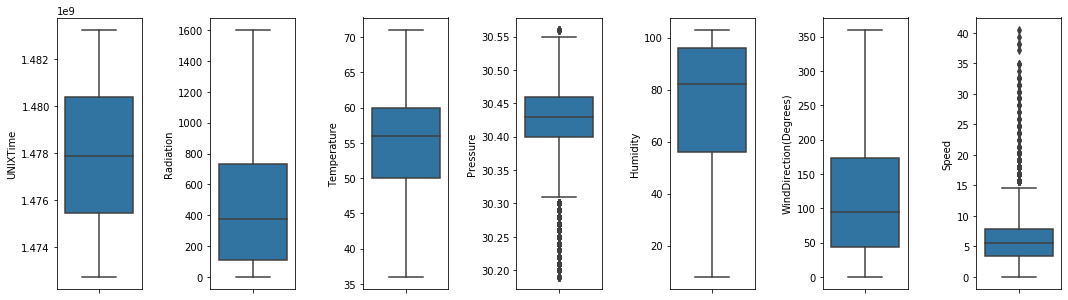

In [91]:
fig, axs = plt.subplots(1,7, figsize=(18,5))
plt.subplots_adjust(wspace=0.8)
for i, feature in enumerate(sun_df.columns[sun_df.dtypes != 'object']):
    sns.boxplot(x=sun_df[feature], orient='v', ax=axs[i])

# Feature Engineering

In [92]:
# add column hour
sun_df['Hour'] = pd.to_datetime(sun_df['Time'], format='%H:%M:%S').dt.hour
# add column month
sun_df['Month'] = pd.to_datetime(sun_df['UNIXTime'].astype(int), unit='s').dt.month
# add time after sunrise
# by seconds
sun_df['SecondsAfterSunRise'] = (pd.to_datetime(sun_df['Time'], format='%H:%M:%S') - pd.to_datetime(sun_df['TimeSunRise'], format='%H:%M:%S')).dt.total_seconds()
# by minutes
sun_df['MinutesAfterSunRise'] = sun_df['SecondsAfterSunRise']/60


In [93]:
sun_df.head()

,UNIXTime,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Date,Hour,Month,SecondsAfterSunRise,MinutesAfterSunRise
0,1475208652,18:10:52,6.63,53,30.44,59,118.82,5.62,06:13:00,18:13:00,9/29/2016,18,9,43072.0,717.866667
1,1475208322,18:05:22,10.96,54,30.44,59,154.16,4.50,06:13:00,18:13:00,9/29/2016,18,9,42742.0,712.366667
2,1475208022,18:00:22,19.42,55,30.44,57,58.42,6.75,06:13:00,18:13:00,9/29/2016,18,9,42442.0,707.366667
3,1475207722,17:55:22,27.14,55,30.44,53,47.86,4.50,06:13:00,18:13:00,9/29/2016,17,9,42142.0,702.366667
4,1475207419,17:50:19,33.75,56,30.44,52,74.56,2.25,06:13:00,18:13:00,9/29/2016,17,9,41839.0,697.316667


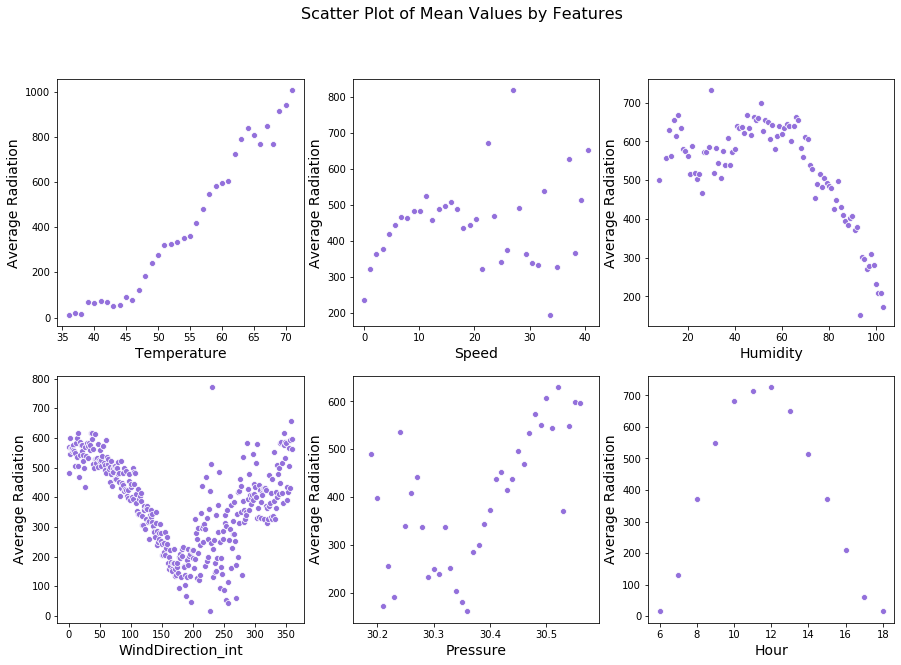

In [94]:
# scatter for mean radiation with features
fea_list = ['Temperature', 'Pressure', 'Humidity', 'WindDirection_int', 'Speed', 'Hour']
sun_df['WindDirection_int'] = round(sun_df['WindDirection(Degrees)'])

fig, axs = plt.subplots(2, 3, figsize=(15,10))

for i, feature in enumerate(fea_list):
    sns.scatterplot(data=sun_df.groupby(by=feature)['Radiation'].mean(), color = 'mediumpurple', ax=axs[i%2, i%3])
    axs[i%2, i%3].set_ylabel('Average Radiation', fontsize = 14)
    axs[i%2, i%3].set_xlabel(feature, fontsize = 14)

fig.suptitle('Scatter Plot of Mean Values by Features', fontsize=16)
plt.show()


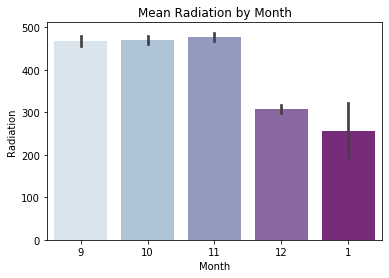

In [95]:
fig, axes = plt.subplots()
sns.barplot(x="Month", y='Radiation', data=sun_df, palette="BuPu", order=[9,10,11,12,1])
plt.title('Mean Radiation by Month')
plt.show()

### Add Dummy Columns for Hour

In [96]:
sun_df = pd.concat([sun_df, pd.get_dummies(sun_df['Hour'], prefix='Hour', prefix_sep='_', drop_first=True)], axis=1)

### Add Dummy Columns for Month

In [97]:
sun_df = pd.concat([sun_df, pd.get_dummies(sun_df['Month'], prefix='Month', prefix_sep='_', drop_first=True)], axis=1)

### Add Higher-Order Terms

In [98]:
sun_df['Speed_2'] = np.square(sun_df['Speed'])
sun_df['Speed_3'] = np.power(sun_df['Speed'], 3)
sun_df['Humidity_2'] = np.square(sun_df['Humidity'])
sun_df['WindDirection_2'] = np.square(sun_df['WindDirection(Degrees)'])
sun_df['Pressure_2'] = np.square(sun_df['Pressure'])
sun_df['Hour_2'] = np.square(sun_df['Hour'])

In [99]:
sun_df.head()

,UNIXTime,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,...,Month_9,Month_10,Month_11,Month_12,Speed_2,Speed_3,Humidity_2,WindDirection_2,Pressure_2,Hour_2
0,1475208652,18:10:52,6.63,53,30.44,59,118.82,5.62,06:13:00,18:13:00,...,1,0,0,0,31.5844,177.504328,3481,14118.1924,926.5936,324
1,1475208322,18:05:22,10.96,54,30.44,59,154.16,4.50,06:13:00,18:13:00,...,1,0,0,0,20.2500,91.125000,3481,23765.3056,926.5936,324
2,1475208022,18:00:22,19.42,55,30.44,57,58.42,6.75,06:13:00,18:13:00,...,1,0,0,0,45.5625,307.546875,3249,3412.8964,926.5936,324
3,1475207722,17:55:22,27.14,55,30.44,53,47.86,4.50,06:13:00,18:13:00,...,1,0,0,0,20.2500,91.125000,2809,2290.5796,926.5936,289
4,1475207419,17:50:19,33.75,56,30.44,52,74.56,2.25,06:13:00,18:13:00,...,1,0,0,0,5.0625,11.390625,2704,5559.1936,926.5936,289


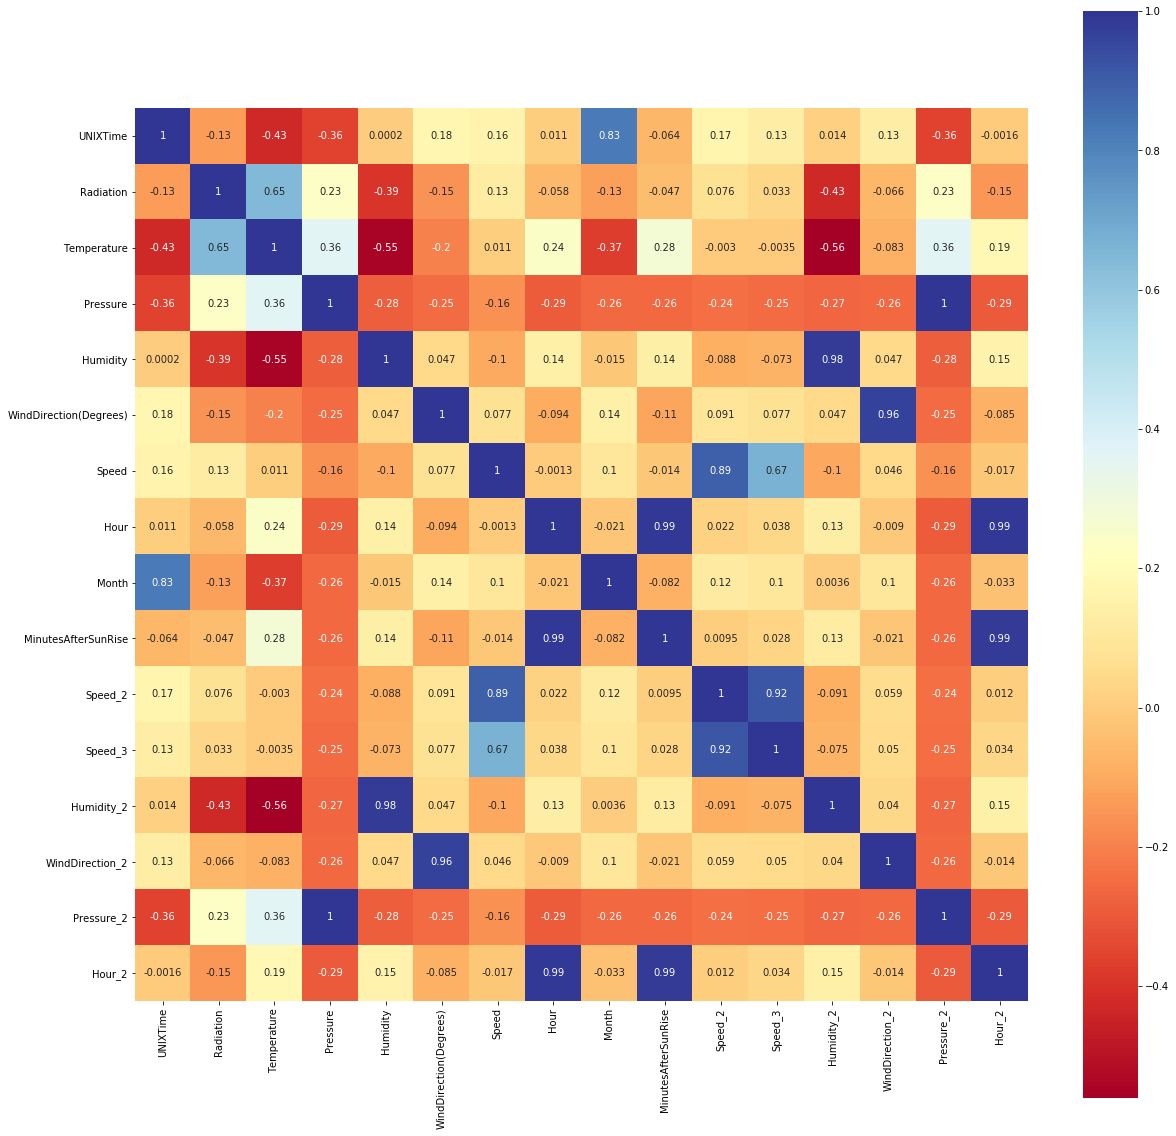

In [103]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(sun_df[['UNIXTime', 'Time', 'Radiation', 'Temperature', 'Pressure', 'Humidity',
                    'WindDirection(Degrees)', 'Speed', 'TimeSunRise', 'TimeSunSet', 'Date',
                    'Hour', 'Month', 'MinutesAfterSunRise', 'Speed_2',
                    'Speed_3', 'Humidity_2', 'WindDirection_2', 'Pressure_2', 'Hour_2']].corr(), cmap='RdYlBu', annot=True, square=True, ax=ax)

# Export the Dataset

In [101]:
sun_df.to_csv('Solar_Features.csv', index=False)